
### Implementação da PINN

<ipython-input-5-558bdc78dc6e>:66: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t_phys = torch.tensor(t_phys, dtype=torch.float32).to(device)


Epoch 0: Loss = 4314.434570
Epoch 500: Loss = 0.700770
Epoch 1000: Loss = 0.287532
Epoch 1500: Loss = 0.124210
Epoch 2000: Loss = 0.352302
Epoch 2500: Loss = 0.036049
Epoch 3000: Loss = 0.053939
Epoch 3500: Loss = 0.116855
Epoch 4000: Loss = 0.229969
Epoch 4500: Loss = 0.998505
Epoch 5000: Loss = 1.555048
Epoch 5500: Loss = 1.478178
Epoch 6000: Loss = 0.044372
Epoch 6500: Loss = 0.365322
Epoch 7000: Loss = 0.310922
Epoch 7500: Loss = 0.045111
Epoch 8000: Loss = 0.037801
Epoch 8500: Loss = 0.070263
Epoch 9000: Loss = 0.126803
Epoch 9500: Loss = 0.516769
Epoch 10000: Loss = 0.928373
Epoch 10500: Loss = 0.265689
Epoch 11000: Loss = 0.425066
Epoch 11500: Loss = 0.032975
Epoch 12000: Loss = 0.112747
Epoch 12500: Loss = 0.274432
Epoch 13000: Loss = 0.798099
Epoch 13500: Loss = 0.865848
Epoch 14000: Loss = 0.038616
Epoch 14500: Loss = 0.028756
Epoch 15000: Loss = 0.069047
Epoch 15500: Loss = 0.947296
Epoch 16000: Loss = 0.053651
Epoch 16500: Loss = 0.030137
Epoch 17000: Loss = 0.030635
Epoch 

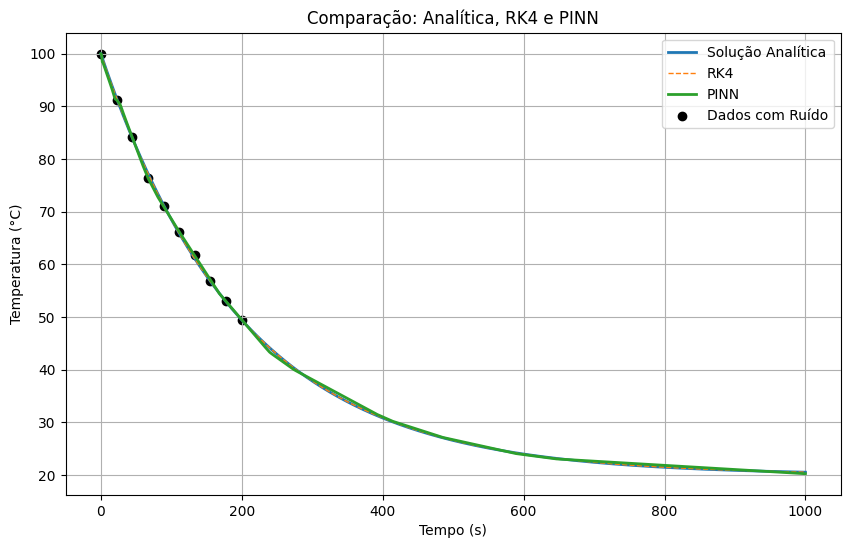

In [5]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# --- PARÂMETROS DO PROBLEMA ---
T_env = 20  # Temperatura ambiente
T0 = 100    # Temperatura inicial
k = 0.005    # Constante de resfriamento

# --- SOLUÇÃO ANALÍTICA ---
def analytical_solution(t):
    return T_env + (T0 - T_env) * np.exp(-k * t)

# --- SOLUÇÃO NUMÉRICA COM RK4 ---
def cooling_ode(t, T):
    return -k * (T - T_env)

t_full = np.linspace(0, 1000, 1000)
rk_sol = solve_ivp(cooling_ode, [0, 1000], [T0], t_eval=t_full)
T_rk = rk_sol.y[0]

# --- DADOS DE TREINO (10 PONTOS ENTRE 0-200s COM RUÍDO) ---
train_t = np.linspace(0, 200, 10)
train_T_clean = analytical_solution(train_t)
noise = np.random.normal(0, 0.5, size=train_T_clean.shape)
train_T = train_T_clean + noise

# --- PINN ---
class PINN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 54),
            nn.ReLU(),
            nn.Linear(54, 54),
            nn.ReLU(),
            nn.Linear(54, 1)
        )

    def forward(self, t):
        return self.net(t)

# --- FUNÇÃO DE PERDA ---
def pinn_loss(model, t_data, T_data, t_phys):
    pred_T = model(t_data)
    data_loss = torch.mean((pred_T - T_data) ** 2)

    t_phys.requires_grad = True
    T_phys = model(t_phys)
    dT_dt = torch.autograd.grad(T_phys, t_phys, torch.ones_like(T_phys), create_graph=True)[0]
    phys_residual = dT_dt + k * (T_phys - T_env)
    phys_loss = torch.mean(phys_residual ** 2)

    return data_loss + phys_loss

# --- TREINAMENTO ---
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = PINN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

t_data = torch.tensor(train_t.reshape(-1, 1), dtype=torch.float32).to(device)
T_data = torch.tensor(train_T.reshape(-1, 1), dtype=torch.float32).to(device)
t_phys = torch.linspace(0, 1000, 1000).reshape(-1, 1)
t_phys = torch.tensor(t_phys, dtype=torch.float32).to(device)

for epoch in range(50000):
    optimizer.zero_grad()
    loss = pinn_loss(model, t_data, T_data, t_phys)
    loss.backward()
    optimizer.step()
    if epoch % 500 == 0:
        print(f"Epoch {epoch}: Loss = {loss.item():.6f}")

# --- PREVISÃO ---
t_pred = torch.tensor(t_full.reshape(-1, 1), dtype=torch.float32).to(device)
with torch.no_grad():
    T_pred = model(t_pred).cpu().numpy()

# --- PLOTAGEM ---
plt.figure(figsize=(10, 6))
plt.plot(t_full, analytical_solution(t_full), label='Solução Analítica', linewidth=2)
plt.plot(t_full, T_rk, '--', label='RK4', linewidth=1)
plt.plot(t_full, T_pred, label='PINN', linewidth=2)
plt.scatter(train_t, train_T, color='black', label='Dados com Ruído')
plt.xlabel('Tempo (s)')
plt.ylabel('Temperatura (°C)')
plt.legend()
plt.title('Comparação: Analítica, RK4 e PINN')
plt.grid(True)
plt.show()


Epoch 0: Loss = 6225.300293, k = 0.04900
Epoch 1000: Loss = 0.110749, k = 0.00437
Epoch 2000: Loss = 0.213582, k = 0.00427
Epoch 3000: Loss = 0.163706, k = 0.00424
Epoch 4000: Loss = 0.142263, k = 0.00429
Epoch 5000: Loss = 0.064730, k = 0.00438
Epoch 6000: Loss = 0.047789, k = 0.00440
Epoch 7000: Loss = 0.048280, k = 0.00442
Epoch 8000: Loss = 0.044616, k = 0.00438
Epoch 9000: Loss = 0.045246, k = 0.00442
Epoch 10000: Loss = 0.040714, k = 0.00448
Epoch 11000: Loss = 0.038780, k = 0.00450
Epoch 12000: Loss = 0.037186, k = 0.00462
Epoch 13000: Loss = 0.035353, k = 0.00466
Epoch 14000: Loss = 0.032413, k = 0.00463
Epoch 15000: Loss = 0.027410, k = 0.00468
Epoch 16000: Loss = 0.029607, k = 0.00471
Epoch 17000: Loss = 0.023744, k = 0.00503
Epoch 18000: Loss = 0.023297, k = 0.00497
Epoch 19000: Loss = 0.021414, k = 0.00487
Epoch 20000: Loss = 0.035812, k = 0.00476
Epoch 21000: Loss = 0.286221, k = 0.00474
Epoch 22000: Loss = 1.171724, k = 0.00479
Epoch 23000: Loss = 0.021697, k = 0.00473
Ep

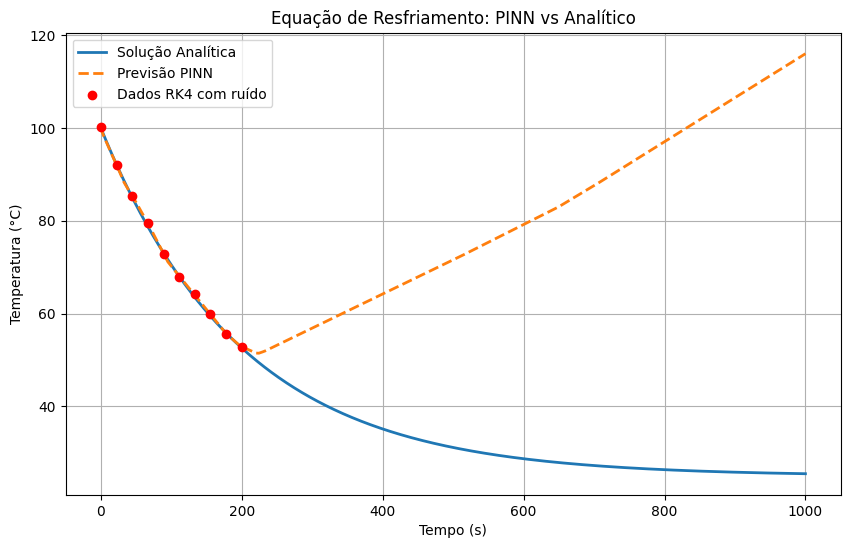

In [13]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# Configurações
torch.manual_seed(42)
np.random.seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# --- PARÂMETROS DO PROBLEMA ---
T_env = 25.0
T0 = 100.0
true_k = 0.005  # valor real
t_min, t_max = 0.0, 1000.0

# --- SOLUÇÃO ANALÍTICA ---
def analytical_solution(t):
    return T_env + (T0 - T_env) * np.exp(-true_k * t)

t_full = np.linspace(t_min, t_max, 1000)
T_full_analytical = analytical_solution(t_full)

# --- DADOS DE TREINAMENTO VIA RK4 ---
def cooling_ode(t, T): return -true_k * (T - T_env)
t_train = np.linspace(0, 200, 10)
sol = solve_ivp(cooling_ode, [t_train[0], t_train[-1]], [T0], t_eval=t_train)
T_train_clean = sol.y[0]
T_train_noisy = T_train_clean + np.random.normal(0, 0.5, size=T_train_clean.shape)

# --- TENSORES DE TREINAMENTO ---
t_data = torch.tensor(t_train, dtype=torch.float32).view(-1, 1).to(device)
T_data = torch.tensor(T_train_noisy, dtype=torch.float32).view(-1, 1).to(device)
t_phys = torch.linspace(0, 200, 50).view(-1, 1).to(device)
t_pred = torch.linspace(0, 1000, 1000).view(-1, 1).to(device)

# --- MODELO PINN ---
class PINN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 32), nn.ReLU(),
            nn.Linear(32, 32), nn.ReLU(),
            nn.Linear(32, 32), nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, t):
        return self.net(t)

model = PINN().to(device)

# --- k como parâmetro treinável ---
k = torch.nn.Parameter(torch.tensor([0.05], dtype=torch.float32, device=device, requires_grad=True))

# --- OTIMIZADOR ---
optimizer = torch.optim.Adam(list(model.parameters()) + [k], lr=1e-3)

# --- FUNÇÃO DE PERDA ---
def pinn_loss(model, t_data, T_data, t_phys, k, lambda_phys=1.0):
    pred_T = model(t_data)
    data_loss = torch.mean((pred_T - T_data)**2)

    t_phys = t_phys.clone().detach().requires_grad_(True)
    T_phys = model(t_phys)
    dT_dt = torch.autograd.grad(T_phys, t_phys, torch.ones_like(T_phys), create_graph=True)[0]
    phys_residual = dT_dt + k * (T_phys - T_env)
    phys_loss = torch.mean(phys_residual**2)

    return data_loss + lambda_phys * phys_loss

# --- TREINAMENTO ---
epochs = 50000
for epoch in range(epochs):
    optimizer.zero_grad()
    loss = pinn_loss(model, t_data, T_data, t_phys, k)
    loss.backward()
    optimizer.step()

    if epoch % 1000 == 0:
        print(f"Epoch {epoch}: Loss = {loss.item():.6f}, k = {k.item():.5f}")

# --- RESULTADO FINAL ---
print(f"\nCoeficiente de resfriamento aprendido pela PINN: k = {k.item():.5f}")

# --- PREVISÃO ---
T_pred = model(t_pred).detach().cpu().numpy()

# --- PLOT COMPARATIVO ---
plt.figure(figsize=(10, 6))
plt.plot(t_full, T_full_analytical, label='Solução Analítica', linewidth=2)
plt.plot(t_pred.cpu(), T_pred, '--', label='Previsão PINN', linewidth=2)
plt.scatter(t_train, T_train_noisy, color='red', label='Dados RK4 com ruído', zorder=5)
plt.xlabel('Tempo (s)')
plt.ylabel('Temperatura (°C)')
plt.title('Equação de Resfriamento: PINN vs Analítico')
plt.grid(True)
plt.legend()
plt.show()
